In [37]:
import pandas as pd
import numpy as np
import perception.util.conversion as conv
import os
import cv2
import scipy
import math
import seaborn as sns
import pickle
import importlib
import statsmodels.api as sm
import itertools
import ground_truth_real
import perception.util.aruco as aruco
import perception.util.conversion as conv

from ground_truth_real import GroundTruthMeasurements
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.interpolate import UnivariateSpline
from scipy.stats import normaltest

plt.style.use("seaborn-v0_8")
sns.set_palette(sns.color_palette("colorblind"))

In [2]:
experiments_dir = f'{os.getcwd()}/../../../../perception_debug'
figures_dir = f'{os.getcwd()}/../../../../figures'
run1_path = f'{experiments_dir}/run1'
run2_path = f'{experiments_dir}/run2'
run3_path = f'{experiments_dir}/run3'

bev_paths_run1 = [f'{run1_path}/bev/{f}' for f in os.listdir(f'{run1_path}/bev') if os.path.isdir(f'{run1_path}/bev/{f}')]
bev_paths_run2 = [f'{run2_path}/bev/{f}' for f in os.listdir(f'{run2_path}/bev') if os.path.isdir(f'{run2_path}/bev/{f}')]
bev_paths_run3 = [f'{run3_path}/bev/{f}' for f in os.listdir(f'{run3_path}/bev') if os.path.isdir(f'{run3_path}/bev/{f}')]

tracking_paths_run1 = [f'{run1_path}/ego/{f}/color' for f in os.listdir(f'{run1_path}/ego') if os.path.isdir(f'{run1_path}/ego/{f}')]
tracking_paths_run2 = [f'{run2_path}/ego/{f}/color' for f in os.listdir(f'{run2_path}/ego') if os.path.isdir(f'{run2_path}/ego/{f}')]
tracking_paths_run3 = [f'{run3_path}/ego/{f}/color' for f in os.listdir(f'{run3_path}/ego') if os.path.isdir(f'{run3_path}/ego/{f}')]

RUN1_2_MEASUREMENTS = GroundTruthMeasurements(
  bev_to_cam_ego_x=-184.8,
  bev_to_cam_ego_y=-39.5,
  bev_to_cam_ego_z=12.5,
  bev_to_back_opp_x=-100.0,
  bev_to_back_opp_y=0.0,
  bev_to_back_opp_z=-120.0,
  ego_top_marker_to_ego_cam_rot=conv.get_rotation_matrix_from_euler(-90, 0, 90, degrees=True),
  opp_top_marker_to_opp_back_marker_rot=conv.get_rotation_matrix_from_euler(-90, 90, 90, degrees=True),
)

RUN3_MEASUREMENTS = GroundTruthMeasurements(
  bev_to_cam_ego_x=-28.7,
  bev_to_cam_ego_y=376.0,
  bev_to_cam_ego_z=-94.9,
  bev_to_back_opp_x=-157.0,
  bev_to_back_opp_y=0.0,
  bev_to_back_opp_z=-116.0,
  ego_top_marker_to_ego_cam_rot=conv.get_rotation_matrix_from_euler(-90, 0, 0, degrees=True),
  opp_top_marker_to_opp_back_marker_rot=conv.get_rotation_matrix_from_euler(-90, 90, 90, degrees=True),
)

## Estimate the standard deviation of the AruCo corners through straight line test

In [4]:
experiments_dir = f'{os.getcwd()}/../../../../perception_debug'
big_path = f'{experiments_dir}/big_25'
small_path = f'{experiments_dir}/small_15'

bev_paths_big = [f'{big_path}/{f}' for f in os.listdir(f'{big_path}') if os.path.isdir(f'{big_path}/{f}')]
bev_paths_small = [f'{small_path}/{f}' for f in os.listdir(f'{small_path}') if os.path.isdir(f'{small_path}/{f}')]

In [24]:
big_corners = [pd.read_csv(f'{path}/bev/{cam}/aruco_corners.csv')[["5"]].dropna() for path, cam in itertools.product(bev_paths_big, ['left', 'right'])]
small_corners = [pd.read_csv(f'{path}/bev/{cam}/aruco_corners.csv')[["12"]].dropna() for path, cam in itertools.product(bev_paths_small, ['left', 'right'])]

def string_to_numpy(string: str) -> np.ndarray:
  # Remove extra brackets and newline characters
  cleaned_str = string.replace('[', '').replace(']', '').replace('\n', '')

  # Split the string into individual numbers
  numbers = list(map(float, cleaned_str.split()))

  # Convert the list of numbers into a numpy array and reshape it
  array = np.array(numbers).reshape(1, 4, 2)

  return array

# there are 4 (x, y) coordinates for each corner
# for each row, extract the x and y coordinates and store them in separate list
def extract_corner_dfs(raw_corners, marker_id):
  # separate each corner into its own column
  corners_clean = [[[] for _ in range(4)] for _ in range(len(raw_corners))]

  for i, run in enumerate(raw_corners):
    for corners in run[str(marker_id)]:
      for j in range(4):
        corners_clean[i][j].append(corners[0][j])

  for i, run in enumerate(corners_clean):
    for j in range(4):
      corners_clean[i][j] = pd.DataFrame(corners_clean[i][j], columns=["x", "y"])

  return corners_clean

for i, corners in enumerate(big_corners):
  corners["5"] = corners["5"].apply(string_to_numpy)

for i, corners in enumerate(small_corners):
  corners["12"] = corners["12"].apply(string_to_numpy)

big_corners_clean = extract_corner_dfs(big_corners, 5)
small_corners_clean = extract_corner_dfs(small_corners, 12)

In [234]:
# perform linear regression on the corners
def linear_regression(corners):
  # store the results of the linear regression
  results = []

  for corner in corners:
    x = corner["x"].values
    y = corner["y"].values

    # perform the linear regression
    # print(scipy.stats.linregress(x, y))
    # model = sm.OLS(y, x)
    results.append(scipy.stats.linregress(x, y))

  return results

big_results = linear_regression(big_corners_clean[3])

# get standard deviation of residuals from scipy.stats.linregress
preds = [result.slope * big_corners_clean[3][i]["x"] + result.intercept \
          for i, result in enumerate(big_results)]
residuals = [big_corners_clean[3][i]["y"] - pred for i, pred in enumerate(preds)]
std_devs = [np.std(resid) for resid in residuals]
res_std_errs = [np.sqrt(sum(resid ** 2) / (len(resid) - 2)) for resid in residuals]

std_devs, res_std_errs

([0.2445601950823707,
  0.17583607343787744,
  0.16974293557769665,
  0.25460331577002976],
 [0.24505375803666787,
  0.1761909397391936,
  0.17008550491824925,
  0.25511714740425384])

In [233]:
run_num = 1
# get average standard deviation of residuals for all runs
all_std_errs = []
def get_avg_std_errs(run):
  all_std_errs = []
  for corners in run:
    results = linear_regression(corners)
    preds = [result.slope * corners[i]["x"] + result.intercept \
              for i, result in enumerate(results)]
    residuals = [corners[i]["y"] - pred for i, pred in enumerate(preds)]
    std_devs = [np.std(resid) for resid in residuals]
    res_std_errs = [np.sqrt(sum(resid ** 2) / (len(resid) - 2)) for resid in residuals]
    all_std_errs.append(np.mean(res_std_errs))
  return np.mean(all_std_errs), all_std_errs

big_avg_std_errs, big_all_std_errs = get_avg_std_errs(big_corners_clean)
small_avg_std_errs, small_all_std_errs = get_avg_std_errs(small_corners_clean)

print(f"Average standard deviation of residuals for big marker: {big_avg_std_errs}")
print(f"Average standard deviation of residuals for small marker: {small_avg_std_errs}")

Average standard deviation of residuals for big marker: 0.2321842516835679
Average standard deviation of residuals for small marker: 0.28611459443553816


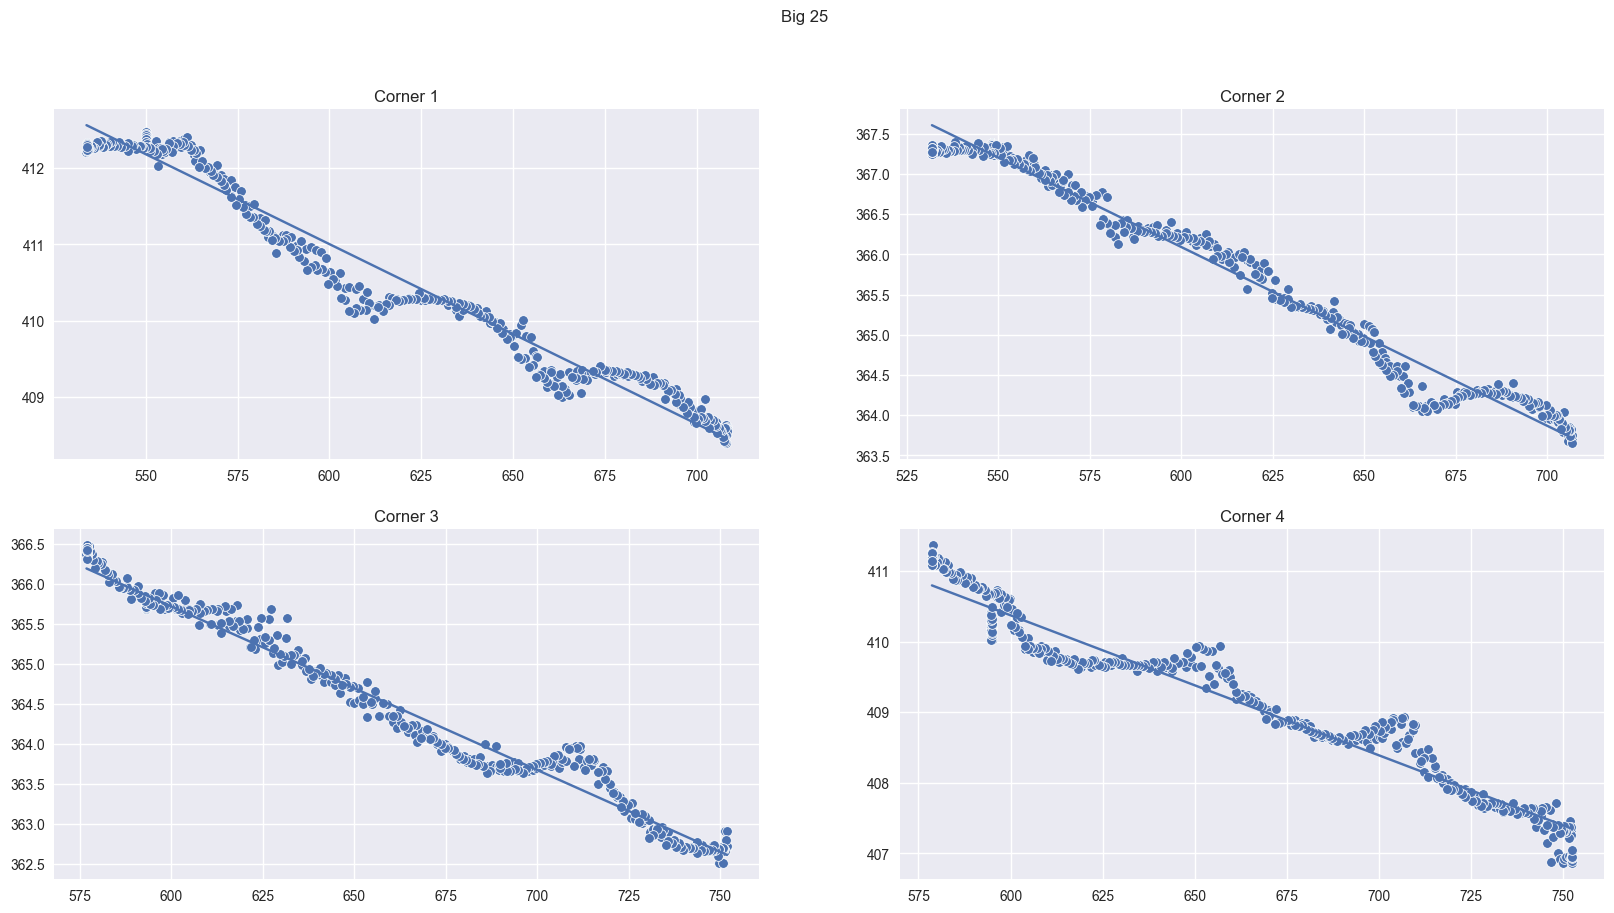

In [102]:
# plot the linear regression from scipy.stats.linregress
def plot_linear_regression(corners, results, title):
  fig, axs = plt.subplots(2, 2, figsize=(20, 10))
  fig.suptitle(title)

  for i, (corner, result) in enumerate(zip(corners, results)):
    x = corner["x"].values
    y = corner["y"].values

    sns.scatterplot(x=x, y=y, ax=axs.flat[i])
    sns.lineplot(x=x, y=result.intercept + result.slope * x, ax=axs.flat[i])

    axs.flat[i].set_title(f"Corner {i + 1}")

  plt.show()

plot_linear_regression(big_corners_clean[3], big_results, "Big 25")

## Perform Monte Carlo simulation on the ground truth relative pose

In [217]:
run1_2_ego_aruco_id = 12
run1_2_opp_aruco_id = 14

run3_ego_aruco_id = 5
run3_opp_aruco_id = 4

def process_raw_corners(raw_corners: pd.DataFrame, ego_aruco_id, opp_aruco_id):
  raw_corners = raw_corners[["time", str(ego_aruco_id), str(opp_aruco_id)]]
  raw_corners.dropna(inplace=True)

  raw_corners[str(ego_aruco_id)] = raw_corners[str(ego_aruco_id)].apply(string_to_numpy)
  raw_corners[str(opp_aruco_id)] = raw_corners[str(opp_aruco_id)].apply(string_to_numpy)

  return raw_corners

all_corners_to_process = [[[path, cam, process_raw_corners(pd.read_csv(f'{path}/bev/{cam}/aruco_corners.csv'), run1_2_ego_aruco_id, run1_2_opp_aruco_id)] for path in run] \
  for run, cam in itertools.product([bev_paths_run1, bev_paths_run2], ['left', 'right'])
] + [[[path, cam, process_raw_corners(pd.read_csv(f'{path}/bev/{cam}/aruco_corners.csv'), run3_ego_aruco_id, run3_opp_aruco_id)] for path in run] \
  for run, cam in itertools.product([bev_paths_run3], ['left', 'right'])]

/tmp/ipykernel_59227/2500827778.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_corners.dropna(inplace=True)
/tmp/ipykernel_59227/2500827778.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_corners[str(ego_aruco_id)] = raw_corners[str(ego_aruco_id)].apply(string_to_numpy)
/tmp/ipykernel_59227/2500827778.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [35]:
run3_left_corners = [pd.read_csv(f'{path}/bev/left/aruco_corners.csv') for path in bev_paths_run3[:5]]
run3_right_corners = [pd.read_csv(f'{path}/bev/right/aruco_corners.csv') for path in bev_paths_run3[:5]]

run3_left_corners = [corners[["time", str(run3_ego_aruco_id), str(run3_opp_aruco_id)]] for corners in run3_left_corners]
run3_right_corners = [corners[["time", str(run3_ego_aruco_id), str(run3_opp_aruco_id)]] for corners in run3_right_corners]

In [235]:
small_avg_std_errs

0.28611459443553816

In [277]:
# apply monte carlo simulation to the corners and solvePnP
from perception.scripts.process_bev import BEVProcessor
import perception.scripts.ground_truth_real as ground_truth_real

left_intrinsics = np.loadtxt(f'{experiments_dir}/big_25/24_10_03_18:24:56/bev/left/intrinsics.txt')
left_dist_coeffs = np.loadtxt(f'{experiments_dir}/big_25/24_10_03_18:24:56/bev/left/dist_coeffs.txt')
right_intrinsics = np.loadtxt(f'{experiments_dir}/big_25/24_10_03_18:24:56/bev/right/intrinsics.txt')
right_dist_coeffs = np.loadtxt(f'{experiments_dir}/big_25/24_10_03_18:24:56/bev/right/dist_coeffs.txt')

left_new_intrinsics, _ = cv2.getOptimalNewCameraMatrix(left_intrinsics, left_dist_coeffs, (1280, 720), alpha=1)
right_new_intrinsics, _ = cv2.getOptimalNewCameraMatrix(right_intrinsics, right_dist_coeffs, (1280, 720), alpha=1)

bev_processor = BEVProcessor('')

def monte_carlo_pose(path, corners: pd.DataFrame, ego_aruco_id, opp_aruco_id, intrinsics, marker_size, num_samples=1000, measurements=RUN3_MEASUREMENTS, corner_stdev=0.25):
  # create a list to store the results of the monte carlo simulation
  results = []
  half_marker_size = marker_size / 2

  # Define the 4 corners of the ArUco marker
  marker_obj_points = np.array([[
      [-half_marker_size, half_marker_size, 0],
      [half_marker_size, half_marker_size, 0],
      [half_marker_size, -half_marker_size, 0],
      [-half_marker_size, -half_marker_size, 0]
  ]], dtype=np.float32)

  os.makedirs(f"{path}/monte_carlo_samples", exist_ok=True)

  for index, row in corners.iterrows():
    result = []
    ego_corners = row[str(ego_aruco_id)]
    opp_corners = row[str(opp_aruco_id)]
    for i in range(num_samples):
      # add noise to the corner
      noisy_ego_corner = ego_corners + np.random.normal(0, corner_stdev, ego_corners.shape)
      noisy_opp_corner = opp_corners + np.random.normal(0, corner_stdev, opp_corners.shape)

      _, ego_rvecs, ego_tvecs, reproj_errors = cv2.solvePnPGeneric(marker_obj_points, noisy_ego_corner, 
        intrinsics, None, flags=cv2.SOLVEPNP_IPPE_SQUARE)
      _, opp_rvecs, opp_tvecs, reproj_errors = cv2.solvePnPGeneric(marker_obj_points, noisy_opp_corner,
        intrinsics, None, flags=cv2.SOLVEPNP_IPPE_SQUARE)

      ego_rvec, ego_tvec, ego_quat, ego_roll, ego_pitch, ego_yaw = bev_processor.select_best_pnp_pose(
        ego_rvecs, ego_tvecs, reproj_errors)
      opp_rvec, opp_tvec, opp_quat, opp_roll, opp_pitch, opp_yaw = bev_processor.select_best_pnp_pose(
        opp_rvecs, opp_tvecs, reproj_errors)

      ground_truth_rel_tvec, ground_truth_rel_euler = ground_truth_real.get_ground_truth_rel_pose_ego_cam_frame(
        ego_rvec.flatten(), ego_tvec.flatten(),
        opp_rvec.flatten(), opp_tvec.flatten(),
        measurements
      )

      result.append({"tvec": ground_truth_rel_tvec.flatten(), "euler": np.array(ground_truth_rel_euler)})
    
    # generate dataframe for euler angles
    euler_df = pd.DataFrame([sample["euler"] for sample in result], columns=["roll", "pitch", "yaw"])
    euler_df = ground_truth_real.stabilise_euler_angles(euler_df, ["roll", "pitch", "yaw"])

    # compute the mean and standard deviation of the results
    tvecs = np.array([sample["tvec"] for sample in result])
    eulers = np.array(euler_df.values)
    poses = np.concatenate((tvecs, eulers), axis=1)

    tvec_mean = np.mean(tvecs, axis=0)
    tvec_std = np.std(tvecs, axis=0, ddof=1)
    tvec_95 = np.percentile(tvecs, [2.5, 97.5], axis=0)

    euler_mean = np.mean(eulers, axis=0)
    euler_std = np.std(eulers, axis=0, ddof=1)
    euler_95 = np.percentile(eulers, [2.5, 97.5], axis=0)

    # compute 6d covariance matrix
    cov = np.cov(poses.T)
    
    output_df = pd.DataFrame(poses, columns=["tx", "ty", "tz", "roll", "pitch", "yaw"])
    output_df["time"] = row["time"]
    output_df.to_csv(f"{path}/monte_carlo_samples/{index}.csv", index=False)
    
    results.append({
      'time': row["time"],
      'mean': {'tvec': tvec_mean, 'euler': euler_mean},
      'std': {'tvec': tvec_std, 'euler': euler_std},
      '95': {'tvec': tvec_95, 'euler': euler_95},
      'cov': cov
    })

  return results

for i, run in enumerate(all_corners_to_process):
  for j, (path, cam, corners) in enumerate(run):
    # if os.path.exists(f"{path}/bev/{cam}/monte_carlo_results.pkl"):
    #   print(f"Path {path}, Run {i + 1}, Repeat {j + 1}, Camera: {cam} already processed")
    #   continue
    if cam == 'left':
      intrinsics = left_new_intrinsics
    else:
      intrinsics = right_new_intrinsics

    if 'run1' in path or 'run2' in path:
      results = monte_carlo_pose(f"{path}/bev/{cam}", corners, run1_2_ego_aruco_id, run1_2_opp_aruco_id, intrinsics,
                             marker_size=0.15, num_samples=1000, measurements=RUN1_2_MEASUREMENTS, corner_stdev=small_avg_std_errs)
      pickle.dump(results, open(f"{path}/bev/{cam}/monte_carlo_results.pkl", "wb"))
    else:
      results = monte_carlo_pose(f"{path}/bev/{cam}", corners, run3_ego_aruco_id, run3_opp_aruco_id, intrinsics, 
                            marker_size=0.25, num_samples=1000, measurements=RUN3_MEASUREMENTS, corner_stdev=big_avg_std_errs)
      pickle.dump(results, open(f"{path}/bev/{cam}/monte_carlo_results.pkl", "wb"))
    
    print(f"Path {path}, Run {i + 1}, Repeat {j + 1}, Camera: {cam}")
    print(f"Mean tvec: {results[0]['mean']['tvec']}")
    print(f"Mean euler: {results[0]['mean']['euler']}")
    print(f"Std tvec: {results[0]['std']['tvec']}")
    print(f"Std euler: {results[0]['std']['euler']}")
    print(f"95 tvec: {results[0]['95']['tvec']}")
    print(f"95 euler: {results[0]['95']['euler']}")

Skipping path /media/rl16432/Shared/Documents/Engineering/SOFTENG700/autonomous_f1tenth/src/perception/perception/scripts/../../../../perception_debug/run1/bev/24_09_15_18:50:11, Run 1, Repeat 1, Camera: left
Skipping path /media/rl16432/Shared/Documents/Engineering/SOFTENG700/autonomous_f1tenth/src/perception/perception/scripts/../../../../perception_debug/run1/bev/24_09_15_18:58:08, Run 1, Repeat 2, Camera: left
Skipping path /media/rl16432/Shared/Documents/Engineering/SOFTENG700/autonomous_f1tenth/src/perception/perception/scripts/../../../../perception_debug/run1/bev/24_09_15_19:02:22, Run 1, Repeat 3, Camera: left
Skipping path /media/rl16432/Shared/Documents/Engineering/SOFTENG700/autonomous_f1tenth/src/perception/perception/scripts/../../../../perception_debug/run1/bev/24_09_15_19:06:47, Run 1, Repeat 4, Camera: left
Skipping path /media/rl16432/Shared/Documents/Engineering/SOFTENG700/autonomous_f1tenth/src/perception/perception/scripts/../../../../perception_debug/run1/bev/24_0

### Stabilise all Euler angles

In [146]:
for timestep in range(len(results)):
  euler_df = pd.DataFrame([sample["euler"] for sample in results[timestep]["samples"]], columns=["roll", "pitch", "yaw"])
  euler_df = ground_truth_real.stabilise_euler_angles(euler_df, ["roll", "pitch", "yaw"])
  for i, row in euler_df.iterrows():
    results[timestep]["samples"][i]["euler"] = row.values

{'tvec': array([0.0158993909, 0.1554644039, 0.0140613081]), 'euler': array([0.4091452726, 3.0016357774, 4.5886629384])}


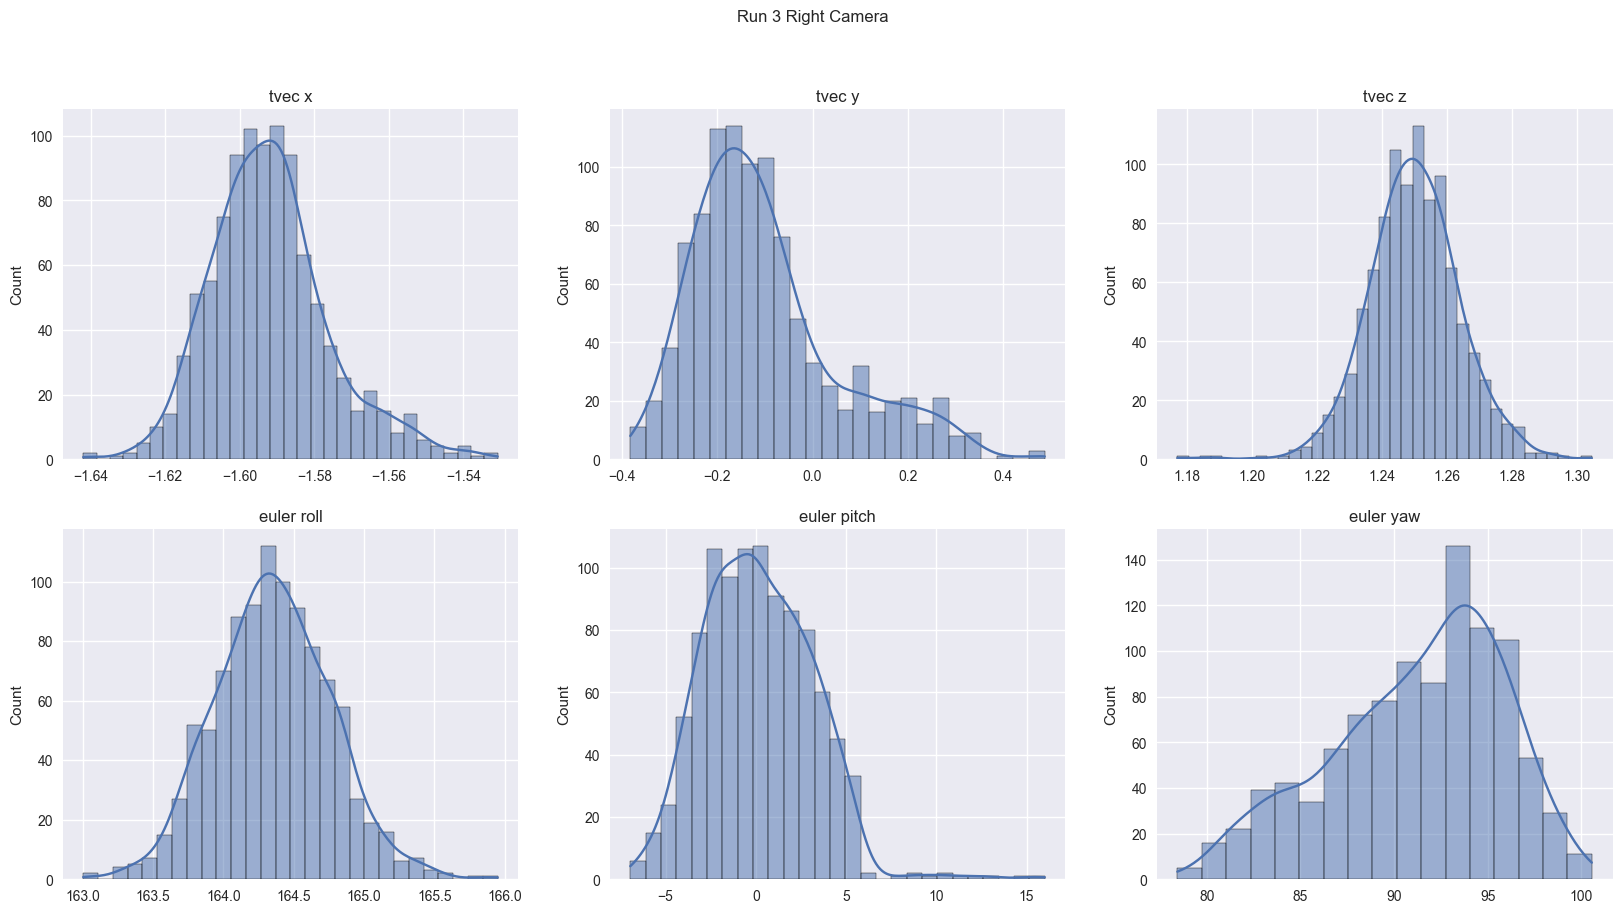

In [173]:
timestep = 0
# plot the distribution of the results
def plot_results(results, title, timestep):
  fig, axs = plt.subplots(2, 3, figsize=(20, 10))
  fig.suptitle(title)
  for i, ax in enumerate(axs[0]):
    sns.histplot([result["tvec"][i] for result in results[timestep]["samples"]], ax=ax, kde=True)
    ax.set_title(f"tvec {['x', 'y', 'z'][i]}")
  for i, ax in enumerate(axs[1]):
    sns.histplot([result["euler"][i] for result in results[timestep]["samples"]], ax=ax, kde=True)
    ax.set_title(f"euler {['roll', 'pitch', 'yaw'][i]}")

  plt.show()

print(results[timestep]["std"])
plot_results(results, "Run 3 Right Camera", timestep)

In [167]:
def back_of_envelope_test(results, timestep, interval=0.95):
  for i, key in enumerate(["tvec", "euler"]):
    for j, axis in enumerate(["x", "y", "z"] if key == "tvec" else ["roll", "pitch", "yaw"]):
      samples = [sample[key][j] for sample in results[timestep]["samples"]]
      mean = results[timestep]["mean"][key][j]
      std = results[timestep]["std"][key][j]

      max_val = max(samples)
      min_val = min(samples)

      print(f"{key} {axis}: Max number of standard deviations from the mean: {abs(mean - max_val) / std}")
      print(f"{key} {axis}: Min number of standard deviations from the mean: {abs(mean - min_val) / std}")

back_of_envelope_test(results, timestep)

tvec x: Max number of standard deviations from the mean: 3.848121298658655
tvec x: Min number of standard deviations from the mean: 3.150185935332694
tvec y: Max number of standard deviations from the mean: 3.7935308431068715
tvec y: Min number of standard deviations from the mean: 1.807427680771183
tvec z: Max number of standard deviations from the mean: 3.883860267519236
tvec z: Min number of standard deviations from the mean: 5.184640864104701
euler roll: Max number of standard deviations from the mean: 3.8985649291242304
euler roll: Min number of standard deviations from the mean: 3.303108381807346
euler pitch: Max number of standard deviations from the mean: 5.285543772074295
euler pitch: Min number of standard deviations from the mean: 2.364215668219755
euler yaw: Max number of standard deviations from the mean: 2.033788456361549
euler yaw: Min number of standard deviations from the mean: 2.7874974322794848


In [166]:
def z_score(confidence_level):
  return scipy.stats.norm.ppf(1 - (1 - confidence_level) / 2)

def back_of_envelope_test(results, timestep, interval=0.95):
  # https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule
  z_score_val = z_score(interval)

  for i, key in enumerate(["tvec", "euler"]):
    for j, axis in enumerate(["x", "y", "z"] if key == "tvec" else ["roll", "pitch", "yaw"]):
      mean = results[timestep]["mean"][key][j] 
      std = results[timestep]["std"][key][j]
      
      # get quantile of the normal distribution
      lower = mean - z_score_val * std
      upper = mean + z_score_val * std

      # get corresponding percentile of all the samples
      samples = [sample[key][j] for sample in results[timestep]["samples"]]
      lower_bound = np.percentile(samples, (1 - interval) / 2 * 100)
      upper_bound = np.percentile(samples, (1 - (1 - interval) / 2) * 100)

      print(f"{key} {axis} lower: {lower}, upper: {upper}")
      print(f"{key} {axis} lower bound: {lower_bound}, upper bound: {upper_bound}")
      
back_of_envelope_test(results, timestep, 0.6827)

tvec x lower: -1.6078440192956764, upper: -1.5760445469605713
tvec x lower bound: -1.6072162479953294, upper bound: -1.5781623570870313
tvec y lower: -0.25727930145346267, upper: 0.053656257639118396
tvec y lower bound: -0.24263771509756504, upper bound: 0.053700587267982804
tvec z lower: 1.2358996353644736, upper: 1.2640228621109
tvec z lower bound: 1.237052501421238, upper bound: 1.2630895330625103
euler roll lower: 163.94601024585813, upper: 164.76431855876598
euler roll lower bound: 163.9446719098253, upper bound: 164.77203043944942
euler pitch lower: -2.8612014165442266, upper: 3.1422004891620436
euler pitch lower bound: -2.900153011102105, upper bound: 3.1972534114730906
euler yaw lower: 86.63543628325215, upper: 95.81296143022354
euler yaw lower bound: 86.25274348841981, upper bound: 95.71284668064649


In [175]:
def normal_test(results, timestep):
  # D'Agostino and Pearson's test
  # tvec_tests = [normaltest([result["tvec"][i] for result in results[timestep]["samples"]]) for i in range(3)]
  # euler_tests = [normaltest([result["euler"][i] for result in results[timestep]["samples"]]) for i in range(3)]

  # shapiro-wilk test
  tvec_tests = [stats.shapiro([result["tvec"][i] for result in results[timestep]["samples"]]) for i in range(3)]
  euler_tests = [stats.shapiro([result["euler"][i] for result in results[timestep]["samples"]]) for i in range(3)]

  return tvec_tests, euler_tests

tvec_tests, euler_tests = normal_test(results, timestep)
tvec_tests, euler_tests

([ShapiroResult(statistic=0.9759358135164208, pvalue=8.178438683007379e-12),
  ShapiroResult(statistic=0.9282199146682593, pvalue=1.832943010861932e-21),
  ShapiroResult(statistic=0.9882183277593627, pvalue=3.4048566099278877e-07)],
 [ShapiroResult(statistic=0.9980681879024624, pvalue=0.31237323071341705),
  ShapiroResult(statistic=0.975181623463823, pvalue=4.821191545736146e-12),
  ShapiroResult(statistic=0.9687375650078697, pvalue=7.715990306394931e-14)])

## Propagate Monte Carlo simulation to velocity and acceleration

In [186]:
run3_monte_carlo_dfs = {}

def get_all_monte_carlo_dfs(bev_paths):
  all_monte_carlo_dfs = {}
  for path in bev_paths:
    for cam in ['left', 'right']:
      monte_carlo_dfs = {}
      all_time_steps = sorted(os.listdir(f"{path}/bev/{cam}/monte_carlo_samples"), key=lambda x: int(x.strip(".csv")))
      for csv in all_time_steps:
        num = int(csv.strip(".csv"))
        df = pd.read_csv(f"{path}/bev/{cam}/monte_carlo_samples/{csv}")
        monte_carlo_dfs[num] = df
      all_monte_carlo_dfs[(path, cam)] = monte_carlo_dfs
  return all_monte_carlo_dfs

run1_monte_carlo_dfs = get_all_monte_carlo_dfs(bev_paths_run1)
run2_monte_carlo_dfs = get_all_monte_carlo_dfs(bev_paths_run2)
run3_monte_carlo_dfs = get_all_monte_carlo_dfs(bev_paths_run3)

In [239]:
from perception.scripts.ground_truth_real import SmoothingParams

def get_splines(monte_carlo_dfs, smoothing_params: dict[str, SmoothingParams]):
  
  for (path, cam), dfs in monte_carlo_dfs.items():
    # We need to get the ego poses to get the timestamps
    ego_poses_df = pd.read_csv(f'{path}/bev/{cam}/ego_poses.csv').dropna()

    start_time = int(np.loadtxt(f'{path}/start_time.txt')) / 1e9
    ego_poses_df["time (sec)"] = ego_poses_df["time"] / 1e9
    ego_poses_df["time_norm (sec)"] = ego_poses_df["time (sec)"] - start_time

    timestamps = ego_poses_df["time"]

    os.makedirs(f"{path}/bev/{cam}/monte_carlo_splines", exist_ok=True)
    
    # scuffed way of setting the lowess window dynamically based on the length of trajectory
    new_smoothing_params = {}
    for dim in smoothing_params.keys():
      new_smoothing_params[dim] = SmoothingParams(
        lowess_frac=smoothing_params[dim].lowess.frac / len(ego_poses_df),
        lowess_it=smoothing_params[dim].lowess.it
      )

    for i in range(1000):
      # For each DataFrame, each of which refers to a timestep, we get the i'th sample
      monte_carlo_traj = {n: df.iloc[i] for n, df in dfs.items()}

      # Join all into one df
      monte_carlo_traj = pd.concat(monte_carlo_traj, axis=1).T
      # set time to be the same as the ego poses by matching the index
      monte_carlo_traj["time"] = timestamps.loc[monte_carlo_traj.index]
      monte_carlo_traj.reset_index(drop=True, inplace=True)

      monte_carlo_traj = ground_truth_real.remove_unused_frames(monte_carlo_traj, start_time)
      monte_carlo_traj = ground_truth_real.stabilise_euler_angles(monte_carlo_traj, ["roll", "pitch", "yaw"])
      
      if i == 0:
        print('Length check:', len(monte_carlo_traj))

      # Apply LOWESS smoothing
      smoothed_monte_carlo_traj = ground_truth_real.generate_smoothed_data(monte_carlo_traj, new_smoothing_params.keys(),
                                                                           new_smoothing_params.values(), "lowess")
      
      # Fit spline to smoothed trajectory
      splines = [UnivariateSpline(smoothed_monte_carlo_traj["time_norm (sec)"], smoothed_monte_carlo_traj[dim], k=3, s=0) \
                  for dim in ["tx", "ty", "tz", "roll", "pitch", "yaw"]]
      
      spline_derivs = [spline.derivative() for spline in splines]

      # dump the splines
      pickle.dump(splines, open(f"{path}/bev/{cam}/monte_carlo_splines/splines_{i}.pkl", "wb"))
      
      # # plot the trajectory
      # fig, axs = plt.subplots(2, 3, figsize=(20, 10))
      # plt.tight_layout()
      # # fig.suptitle("Monte Carlo Trajectory")
      # for i, dim in enumerate(["tx", "ty", "tz"]):
      #   sns.lineplot(data=smoothed_monte_carlo_traj, x="time_norm (sec)", y=dim, ax=axs[0][i])
      # for i, dim in enumerate(["roll", "pitch", "yaw"]):
      #   sns.lineplot(data=smoothed_monte_carlo_traj, x="time_norm (sec)", y=dim, ax=axs[1][i])

      # # plot velocity
      # fig, axs = plt.subplots(2, 3, figsize=(20, 10))
      # plt.tight_layout()
      # # fig.suptitle("Monte Carlo Velocity")
      # eval_times = np.arange(0, smoothed_monte_carlo_traj["time_norm (sec)"].max(), 0.001)
      # for i, dim in enumerate(["tx", "ty", "tz"]):
      #   sns.lineplot(x=eval_times, y=spline_derivs[i](eval_times), ax=axs[0][i])
      # for i, dim in enumerate(["roll", "pitch", "yaw"]):
      #   sns.lineplot(x=eval_times, y=spline_derivs[i + 3](eval_times), ax=axs[1][i])
    print(f"Path {path}, Camera {cam} splines generated")

get_splines(run3_monte_carlo_dfs, {
  'tx': SmoothingParams(lowess_frac=15, lowess_it = 1),
  'ty': SmoothingParams(lowess_frac=30, lowess_it = 1),
  'tz': SmoothingParams(lowess_frac=15, lowess_it = 1),
  'roll': SmoothingParams(lowess_frac=10, lowess_it = 1),
  'pitch': SmoothingParams(lowess_frac=30, lowess_it = 1),
  'yaw': SmoothingParams(lowess_frac=30, lowess_it = 1),
})

In [242]:
run1_monte_carlo_dfs_to_process = {(bev_paths_run1[i], cam): run1_monte_carlo_dfs[(bev_paths_run1[i], cam)] for cam in ['left', 'right'] for i in (2, 3)}
run2_monte_carlo_dfs_to_process = {(bev_paths_run2[i], cam): run2_monte_carlo_dfs[(bev_paths_run2[i], cam)] for cam in ['left', 'right'] for i in (2, 6)}

get_splines(run1_monte_carlo_dfs_to_process, {
  'tx': SmoothingParams(lowess_frac=40, lowess_it = 1),
  'ty': SmoothingParams(lowess_frac=70, lowess_it = 1),
  'tz': SmoothingParams(lowess_frac=60, lowess_it = 1),
  'roll': SmoothingParams(lowess_frac=50, lowess_it = 1),
  'pitch': SmoothingParams(lowess_frac=30, lowess_it = 1),
  'yaw': SmoothingParams(lowess_frac=30, lowess_it = 1),
})

get_splines(run2_monte_carlo_dfs_to_process, {
  'tx': SmoothingParams(lowess_frac=50, lowess_it = 3),
  'ty': SmoothingParams(lowess_frac=70, lowess_it = 1),
  'tz': SmoothingParams(lowess_frac=40, lowess_it = 1),
  'roll': SmoothingParams(lowess_frac=60, lowess_it = 1),
  'pitch': SmoothingParams(lowess_frac=70, lowess_it = 1),
  'yaw': SmoothingParams(lowess_frac=70, lowess_it = 1),
})

Length check: 251
Path /media/rl16432/Shared/Documents/Engineering/SOFTENG700/autonomous_f1tenth/src/perception/perception/scripts/../../../../perception_debug/run2/bev/24_09_15_21:37:20, Camera left splines generated
Length check: 224
Path /media/rl16432/Shared/Documents/Engineering/SOFTENG700/autonomous_f1tenth/src/perception/perception/scripts/../../../../perception_debug/run2/bev/24_09_15_21:46:43, Camera left splines generated


In [159]:
smoothing_funcs = ["lowess"]
run1_data = ground_truth_real.process_run_data(ground_truth_real.read_all_runs(bev_paths_run1, tracking_paths_run1), RUN1_2_MEASUREMENTS, smoothing_funcs)
run2_data = ground_truth_real.process_run_data(ground_truth_real.read_all_runs(bev_paths_run2, tracking_paths_run2), RUN1_2_MEASUREMENTS, smoothing_funcs)
run3_data = ground_truth_real.process_run_data(ground_truth_real.read_all_runs(bev_paths_run3, tracking_paths_run3), RUN3_MEASUREMENTS, smoothing_funcs)

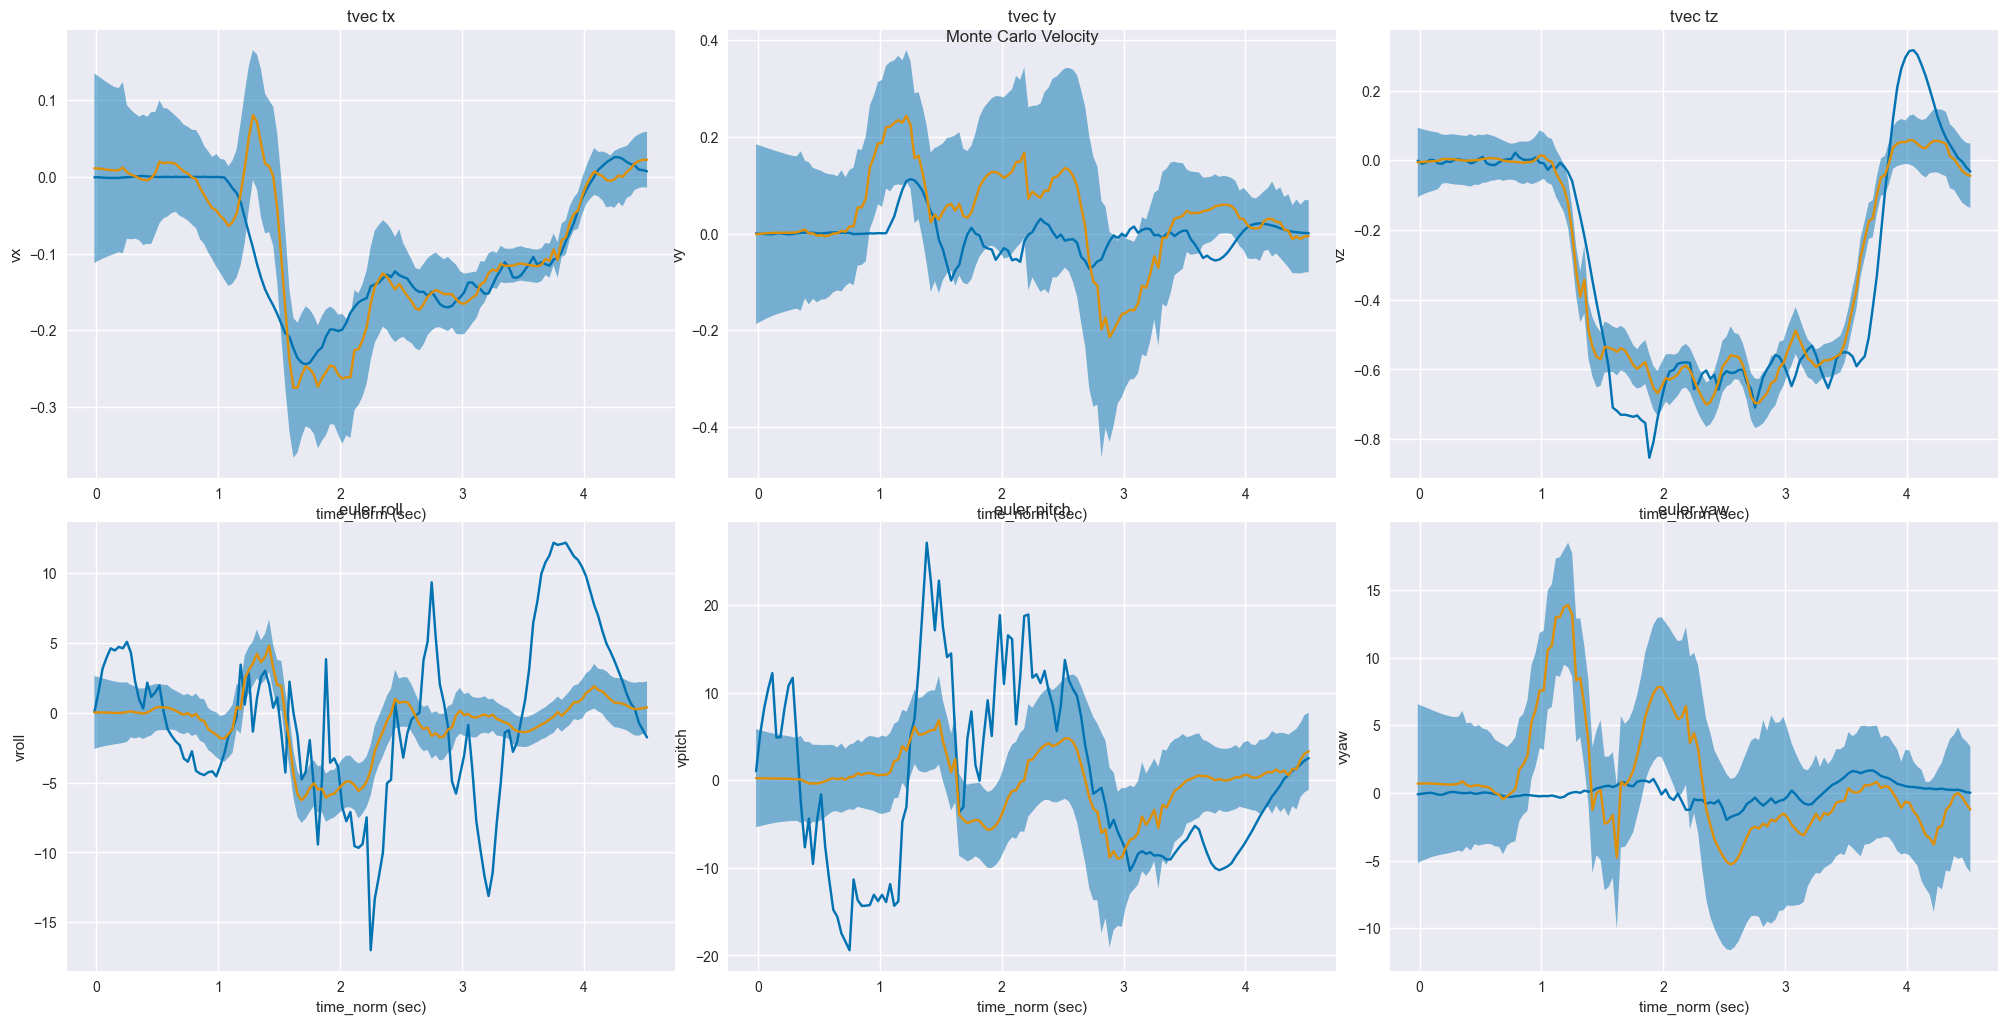

In [250]:
run_num = 2
cam = 'right'
eval_df = run2_data[run_num]["kalman_ca_df"]
gt_df = run2_data[run_num]["lowess"][f"rel_poses_{cam}_df"]

# load splines from pkl
def load_splines(path, cam):
  """
  For each of the 1000 simulations, we load the 6 splines for each dimension
  and their derivatives.
  """
  splines = []
  for i in range(1000):
    splines.append(pickle.load(open(f"{path}/bev/{cam}/monte_carlo_splines/splines_{i}.pkl", "rb")))
  spline_derivs = [list(map(lambda x: x.derivative(), spline)) for spline in splines]
  return splines, spline_derivs

def compute_monte_carlo_pose(splines, spline_derivs, eval_df):
  """
  For each of the 1000 simulations, evaluate the splines
  for each of the 6 dimensions at every time step

  This ensure that the time steps are consistent with the data frame we want to evaluate
  """
  eval_times = eval_df["time_norm (sec)"]
  monte_carlo_pose = []
  for i in range(1000):
    monte_carlo_pose.append(np.array([splines[i][j](eval_times) for j in range(6)]).T)
  return monte_carlo_pose

def compute_monte_carlo_velocity(splines, spline_derivs, eval_df):
  """
  For each of the 1000 simulations, evaluate the spline derivatives 
  for each of the 6 dimensions at every time step.

  This ensure that the time steps are consistent with the data frame we want to evaluate
  """
  eval_times = eval_df["time_norm (sec)"]
  monte_carlo_velocity = []
  for i in range(1000):
    monte_carlo_velocity.append(np.array([spline_derivs[i][j](eval_times) for j in range(6)]).T)
  return monte_carlo_velocity

def get_single_simulation_stats(monte_carlo_velocity, num):
  """
  Plot the velocity histogram for a single time step
  """
  tvecs = np.array([sample[:, :3] for sample in monte_carlo_velocity])
  eulers = np.array([sample[:, 3:] for sample in monte_carlo_velocity])

  tvec_sims = tvecs[:, num, :]
  euler_sims = eulers[:, num, :]

  # plot histogram of tvecs
  fig, axs = plt.subplots(2, 3, figsize=(20, 10))
  plt.tight_layout()
  # fig.suptitle("Monte Carlo Velocity")
  for i, dim in enumerate(["tx", "ty", "tz"]):
    sns.histplot(tvec_sims[:, i], ax=axs[0][i], kde=True)
    axs[0][i].set_title(f"tvec {dim}")
  for i, dim in enumerate(["roll", "pitch", "yaw"]):
    sns.histplot(euler_sims[:, i], ax=axs[1][i], kde=True)
    axs[1][i].set_title(f"euler {dim}")

def get_vel_distribution_stats(monte_carlo_velocity):
  """
  Get the mean, standard deviation and 95% prediction interval for the velocity
  """
  tvecs_v = np.array([sample[:, :3] for sample in monte_carlo_velocity])
  eulers_v = np.array([sample[:, 3:] for sample in monte_carlo_velocity])
  tvec_v_mean = np.mean(tvecs_v, axis=0)
  tvec_v_std = np.std(tvecs_v, axis=0, ddof=1)
  tvec_v_95 = np.percentile(tvecs_v, [2.5, 97.5], axis=0)
  euler_v_mean = np.mean(eulers_v, axis=0)
  euler_v_std = np.std(eulers_v, axis=0, ddof=1)
  euler_v_95 = np.percentile(eulers_v, [2.5, 97.5], axis=0)
  return tvec_v_mean, tvec_v_std, tvec_v_95, euler_v_mean, euler_v_std, euler_v_95

# plot the velocity with prediction interval
def plot_velocity_with_prediction_interval(eval_df, monte_carlo_vel, tvec_mean, tvec_std, tvec_95, euler_mean, euler_std, euler_95, timestep):
  k = stats.norm.ppf(0.975)
  fig, axs = plt.subplots(2, 3, figsize=(20, 10))
  plt.tight_layout()
  fig.suptitle("Monte Carlo Velocity")
  eval_times = eval_df["time_norm (sec)"]

  # also plot the state estimation from the kalman filter
  for i, dim in enumerate(["vx", "vy", "vz"]):
    sns.lineplot(x=eval_times, y=eval_df[dim], ax=axs[0][i])
    axs[0][i].set_title(f"tvec {dim}")
  for i, dim in enumerate(["vroll", "vpitch", "vyaw"]):
    sns.lineplot(x=eval_times, y=eval_df[dim], ax=axs[1][i])
    axs[1][i].set_title(f"euler {dim}")

  for i, dim in enumerate(["tx", "ty", "tz"]):
    sns.lineplot(x=eval_times, y=tvec_mean[:, i], ax=axs[0][i])
    axs[0][i].fill_between(eval_times, tvec_mean[:, i] - k*tvec_std[:, i], tvec_mean[:, i] + k*tvec_std[:, i], alpha=0.5)
    # axs[0][i].fill_between(eval_times, tvec_95[0, i], tvec_95[1, i], alpha=0.5)
    axs[0][i].set_title(f"tvec {dim}")
  for i, dim in enumerate(["roll", "pitch", "yaw"]):
    sns.lineplot(x=eval_times, y=euler_mean[:, i], ax=axs[1][i])
    axs[1][i].fill_between(eval_times, euler_mean[:, i] - k*euler_std[:, i], euler_mean[:, i] + k*euler_std[:, i], alpha=0.5)
    # axs[1][i].fill_between(eval_times, euler_95[0, i], euler_95[1, i], alpha=0.5)
    axs[1][i].set_title(f"euler {dim}")

splines, spline_derivs = load_splines(bev_paths_run2[run_num], cam)
monte_carlo_vel = compute_monte_carlo_velocity(splines, spline_derivs, eval_df)
tvec_vel_mean, tvec_vel_std, tvec_vel_95, euler_vel_mean, euler_vel_std, euler_vel_95 = get_vel_distribution_stats(monte_carlo_vel)

# get_single_simulation_stats(monte_carlo_vel, 25)

plot_velocity_with_prediction_interval(eval_df, monte_carlo_vel, tvec_vel_mean, tvec_vel_std, tvec_vel_95, euler_vel_mean, euler_vel_std, euler_vel_95, 25)

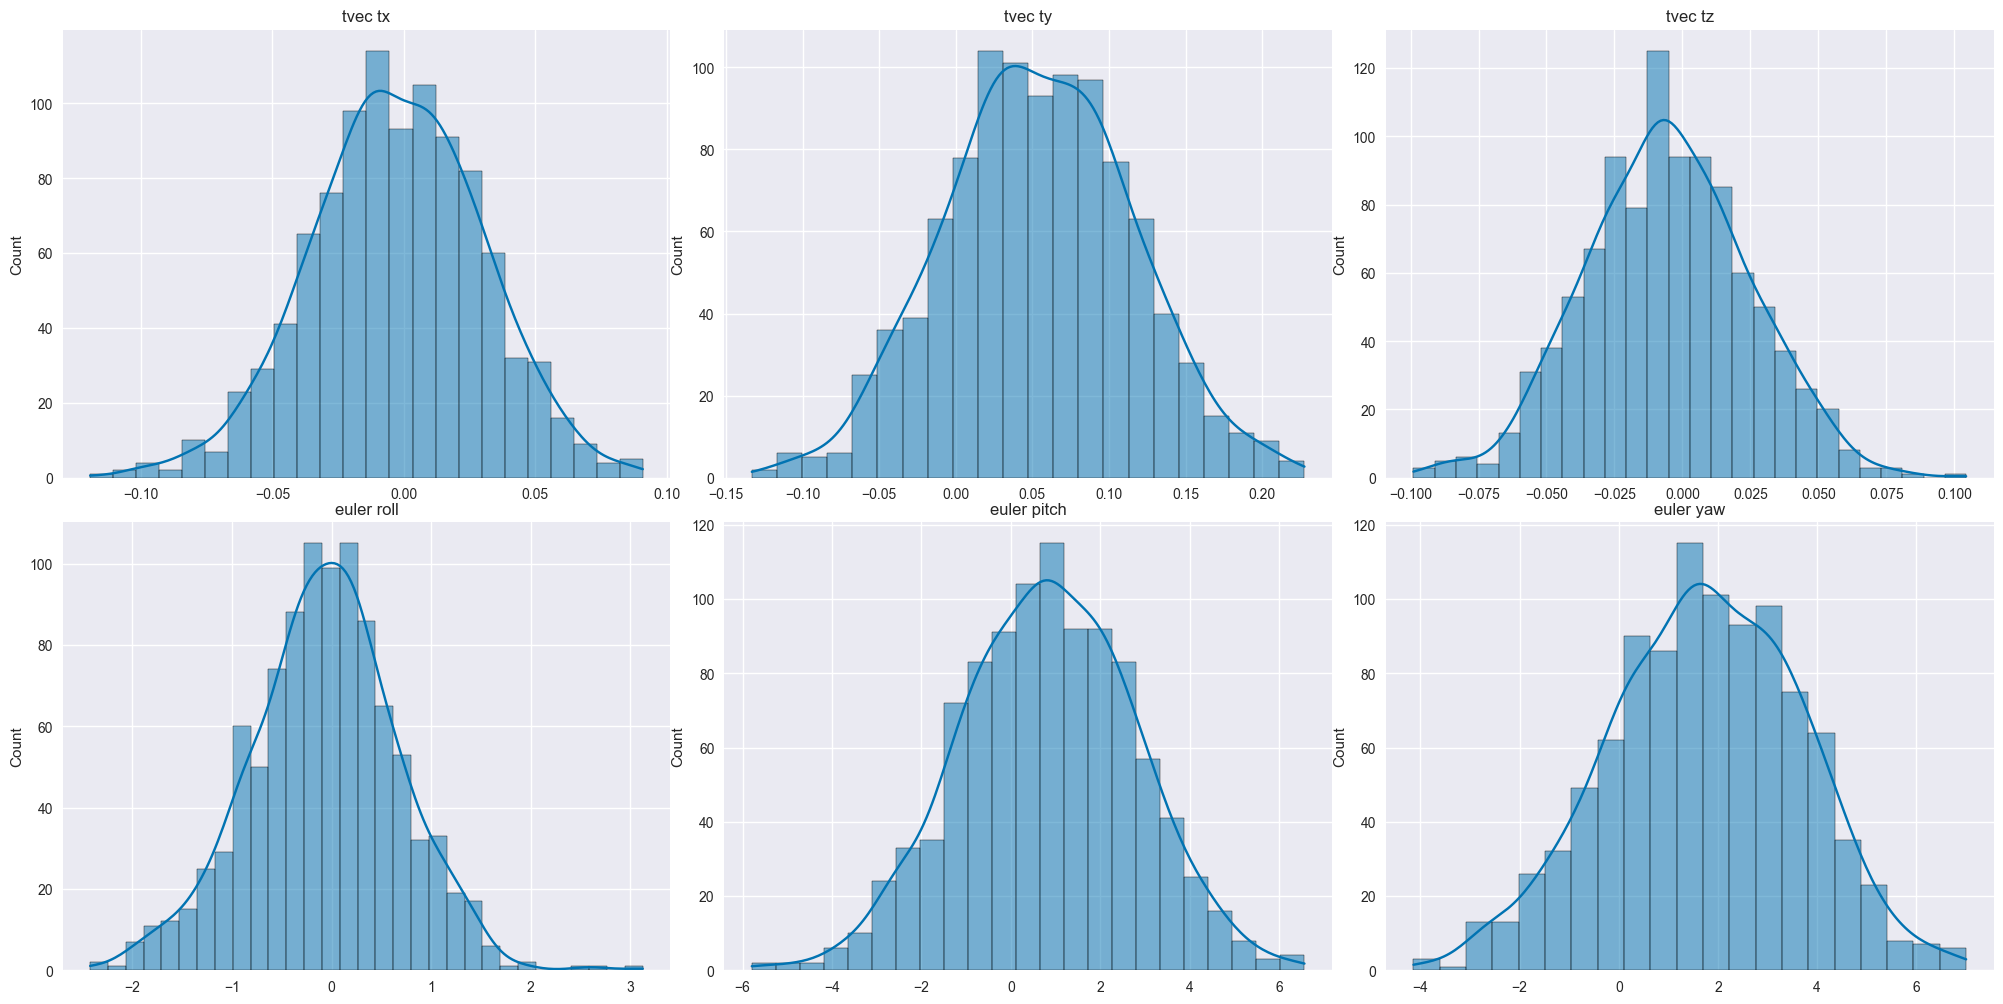

In [246]:
get_single_simulation_stats(monte_carlo_vel, 25)

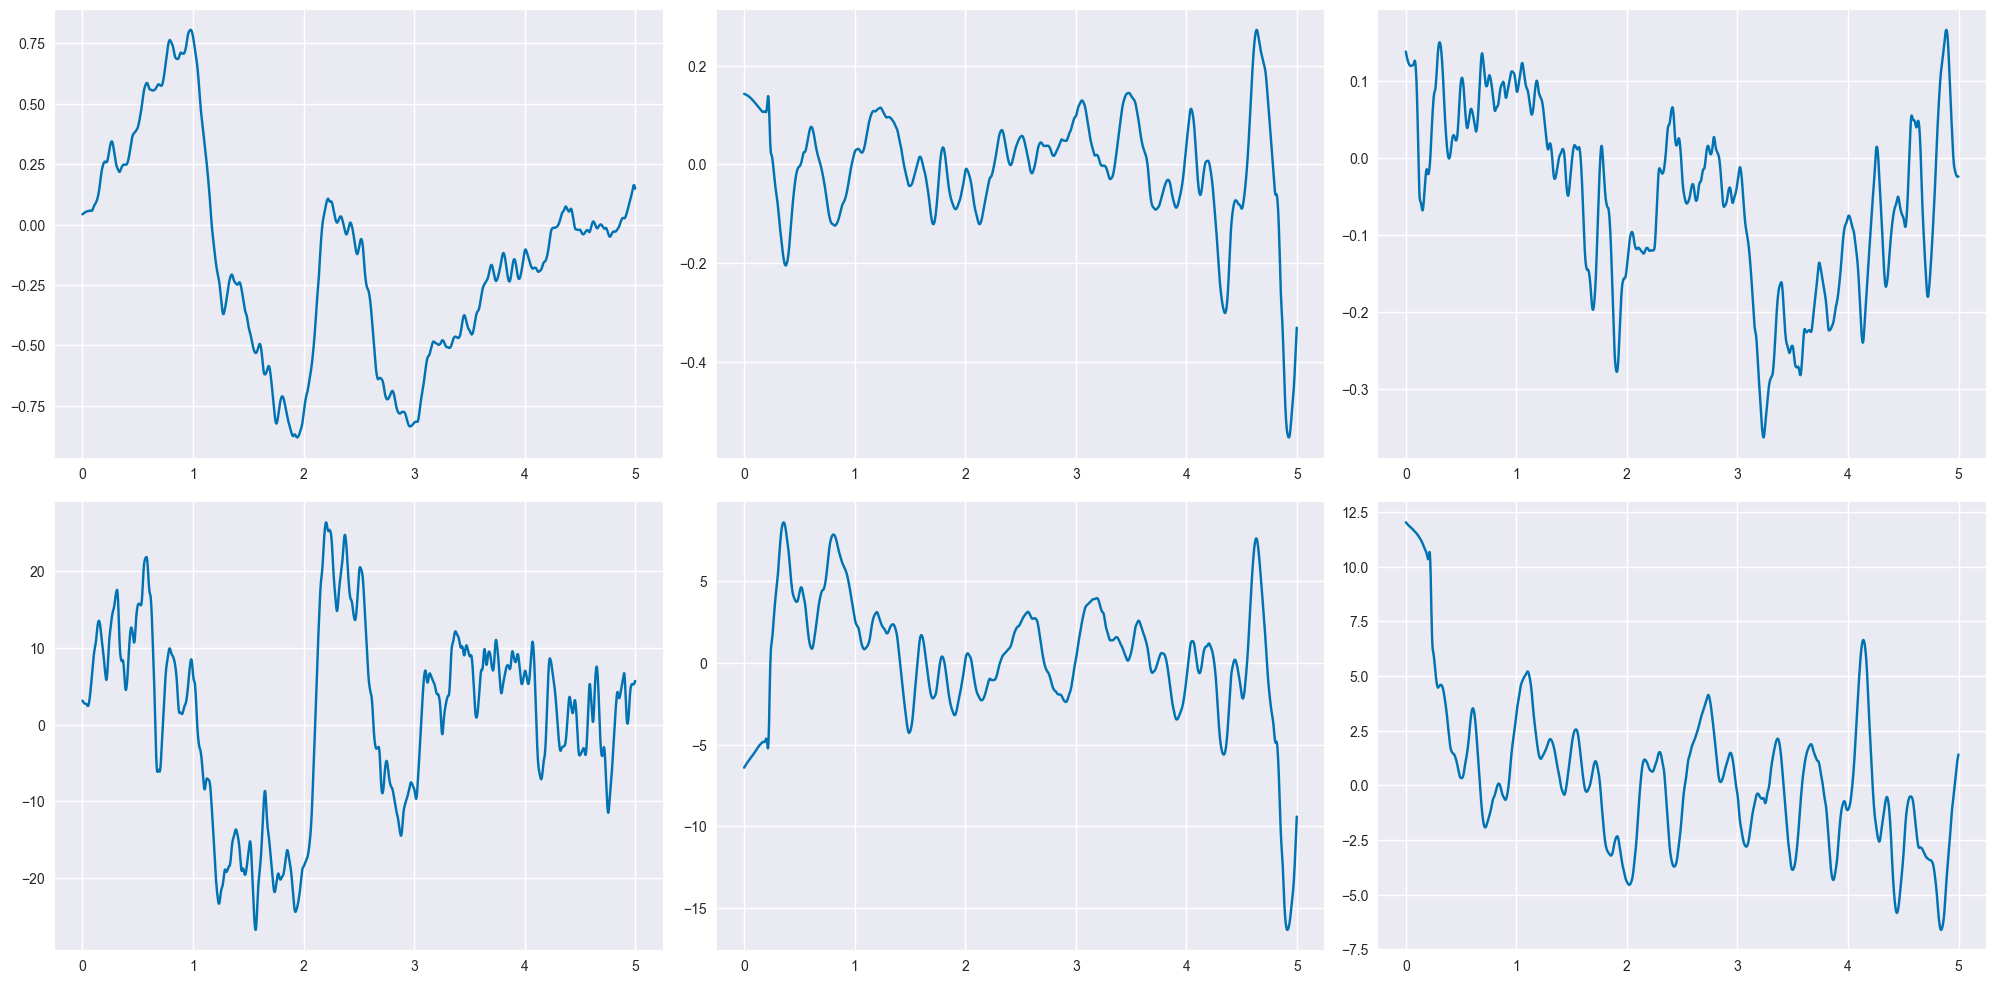

In [133]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
plt.tight_layout()
# fig.suptitle("Monte Carlo Velocity")
eval_times = np.arange(0, 5, 0.001)
for i, dim in enumerate(["tx", "ty", "tz"]):
  sns.lineplot(x=eval_times, y=spline_derivs[0][i](eval_times), ax=axs[0][i])
for i, dim in enumerate(["roll", "pitch", "yaw"]):
  sns.lineplot(x=eval_times, y=spline_derivs[0][i + 3](eval_times), ax=axs[1][i])